In [1]:
import pandas as pd
from tqdm import tqdm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file = "../data/SSCURVES(1-61).xlsx"

In [3]:
def logistic(x, a, k, xc):
    return a/(1 + np.exp(-k*(x-xc)))

In [4]:
def r2_fn(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    
    return r2

100%|███████████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.87it/s]


    index          a          k        xc        r2
0       1   9.722284  25.765146  1.286479  0.997758
1       2   4.980775  34.981564  1.329463  0.998321
2       3   5.809952  36.377351  1.427317  0.999670
3       4   1.488651  41.075665  1.344725  0.999545
4       5  11.070994  22.631975  1.255611  0.997075
..    ...        ...        ...       ...       ...
58     59   3.275427  20.755613  1.264770  0.999109
59     60   3.782172  16.488657  1.274944  0.997922
60     61   2.538357  18.426224  1.277699  0.997563
61     62   3.242959  26.668725  1.443928  0.999947
62    555  11.151417  25.856630  1.353899  0.999413

[63 rows x 5 columns]


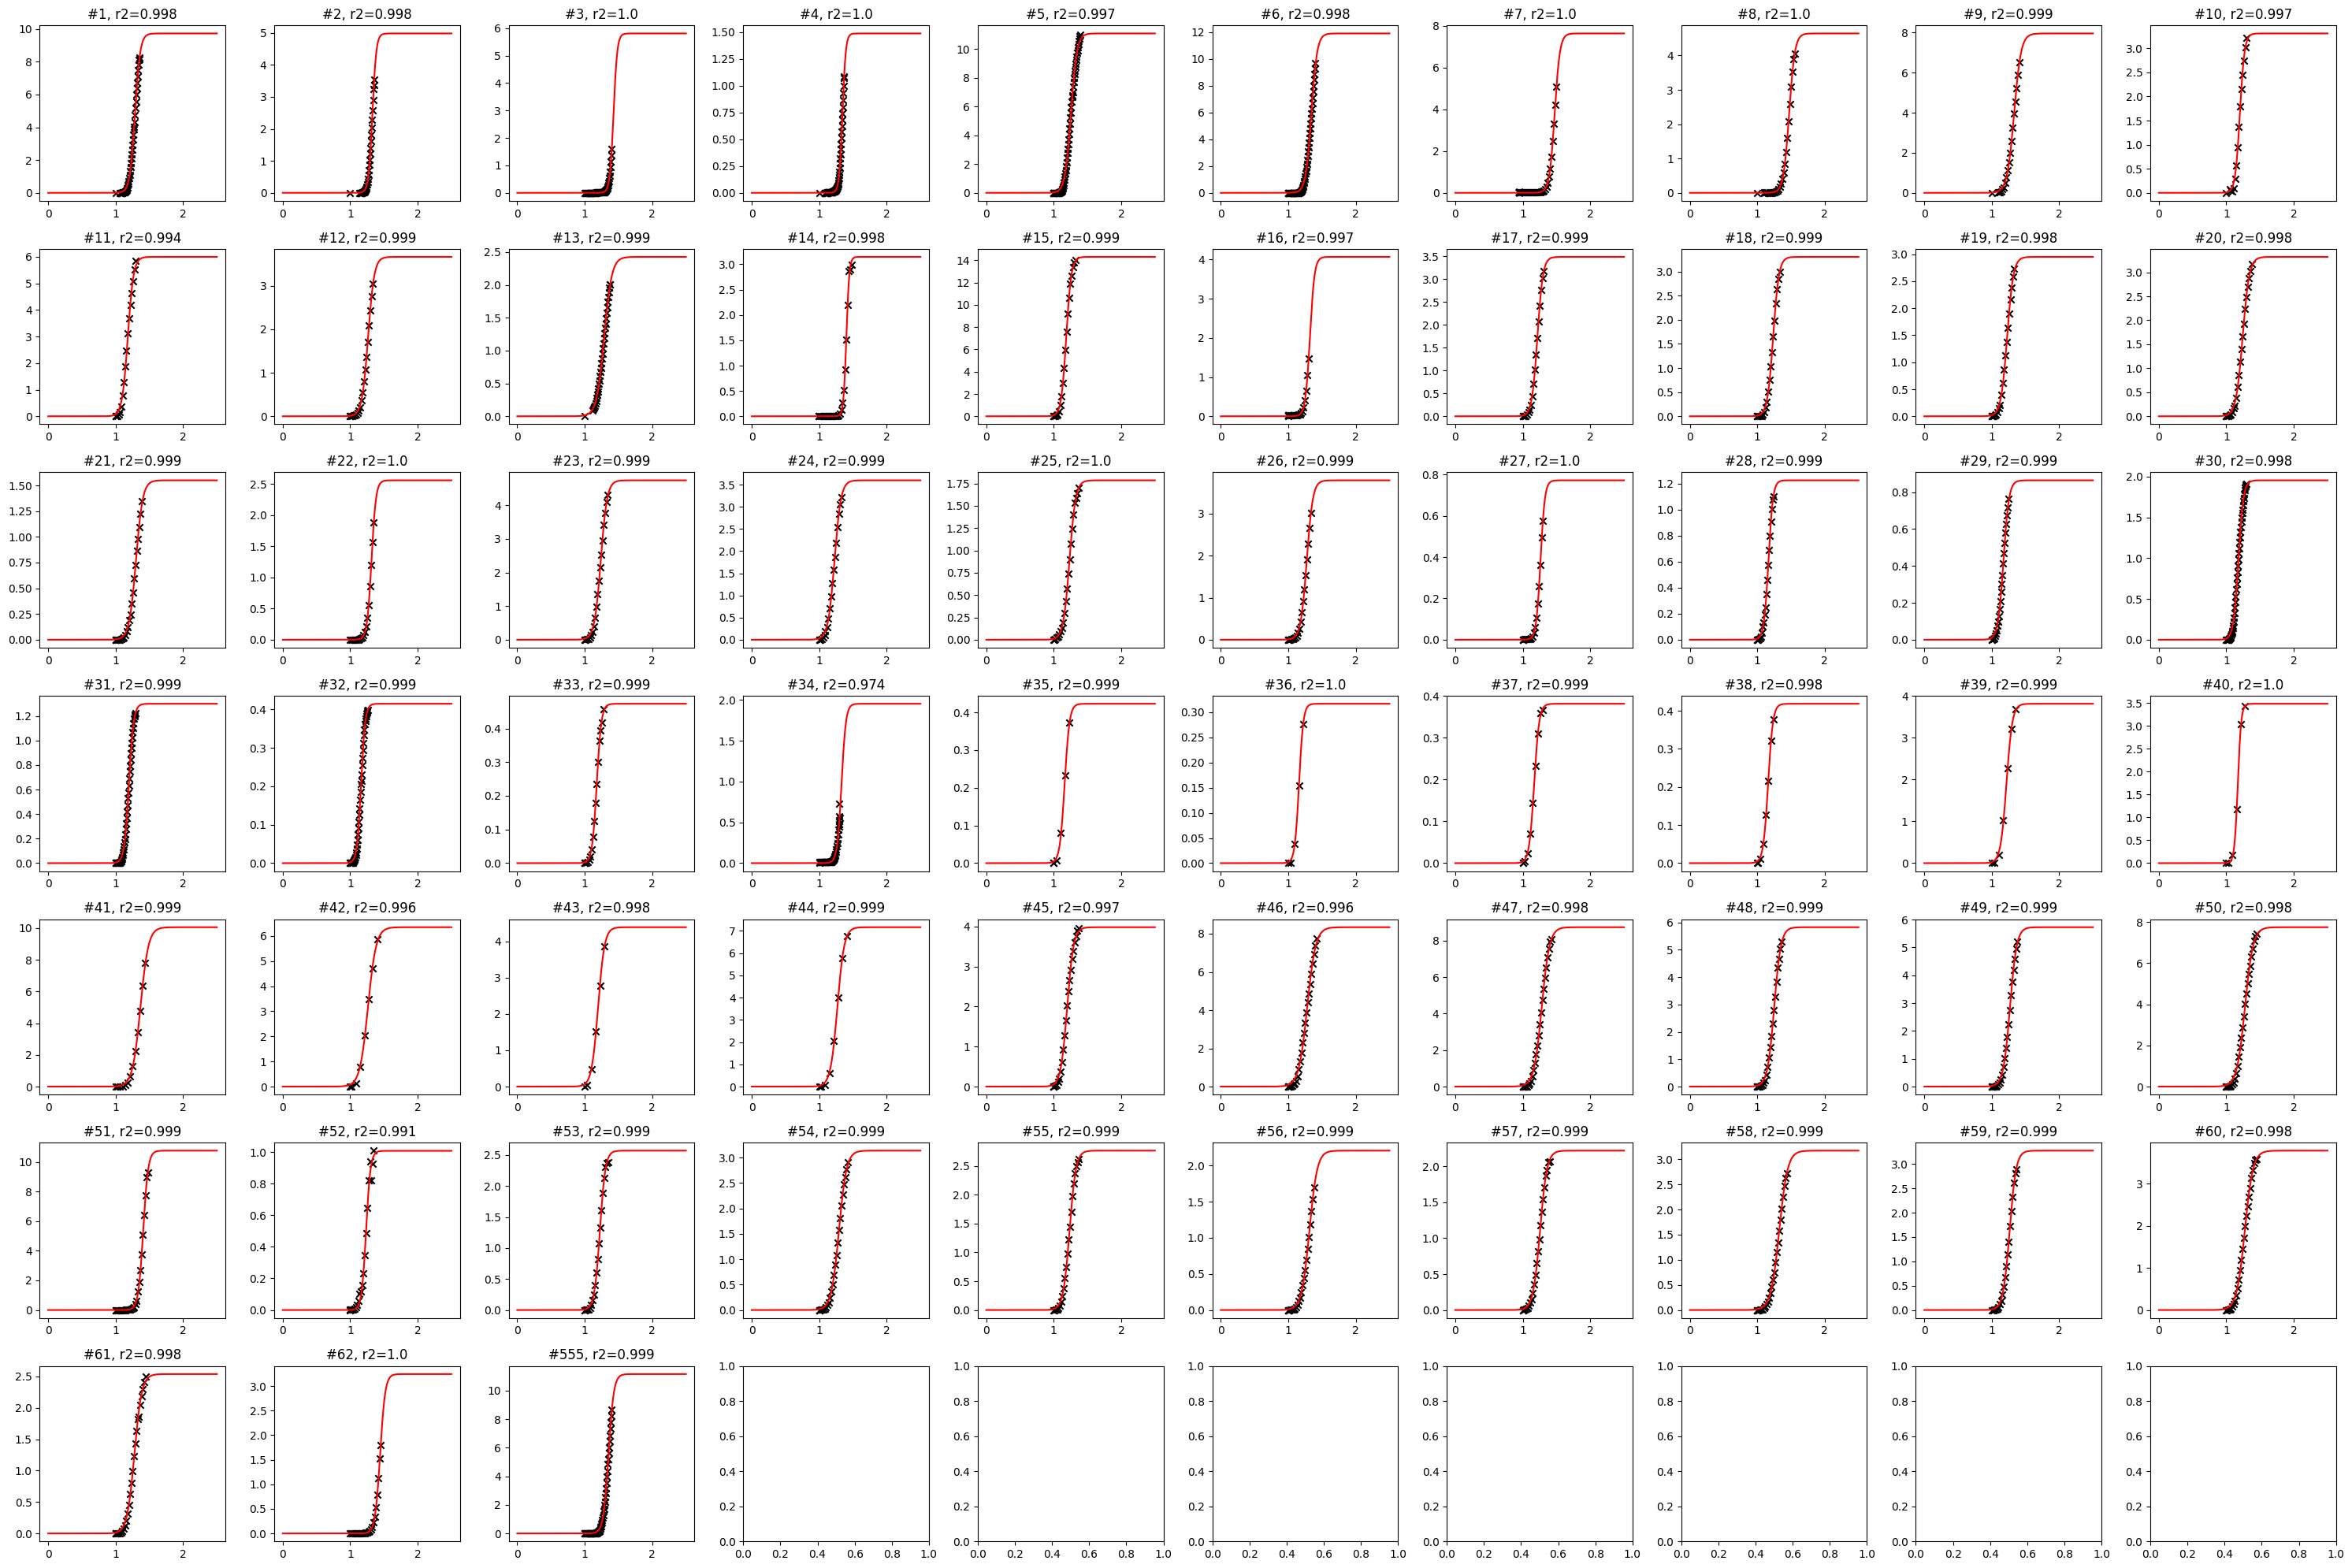

In [5]:
xls = pd.ExcelFile(file)

index_list =  []
a_list = []
k_list = []
xc_list = []

r2_list = []

fig, axs = plt.subplots(7, 10, figsize=(30,20))
x = np.linspace(0, 2.5, 1000)


for sheet, ax in tqdm(zip(xls.sheet_names, axs.flat), total=len(xls.sheet_names), ncols=100):
    df = pd.read_excel(file, sheet_name=sheet)
    df = df.groupby(["Strain"], as_index=False).agg({'Stress': 'mean'})
    df = df.sort_values("Strain")

    x_data = df['Strain']
    y_data = df['Stress']

    popt, _ = curve_fit(logistic, x_data, y_data, bounds=((0, -np.inf, -np.inf), (np.inf, np.inf, np.inf)), maxfev=10000)#bounds=((0, -np.inf,-np.inf,0),(np.inf, np.inf, np.inf,np.inf)), maxfev=10000)
    index_list.append(int(sheet))
    a_list.append(popt[0])
    k_list.append(popt[1])
    xc_list.append(popt[2])

    r2 = r2_fn(y_data, logistic(x_data, *popt))
    r2_list.append(r2)

    ax.scatter(x_data, y_data, marker='x', color='black')
    ax.plot(x, logistic(x, *popt), 'r-')
    ax.set_title(f"#{sheet}, r2={round(r2, 3)}")


data = {
    "index": index_list,
    "a": a_list,
    "k": k_list,
    "xc": xc_list,
    "r2": r2_list,
}

df = pd.DataFrame.from_dict(data)
print(df)

plt.tight_layout()
plt.show()


In [6]:
df.to_csv("outputs/logistic_targets.csv", index=False) # We have our own indices.

array([[<AxesSubplot: title={'center': 'r2'}>]], dtype=object)

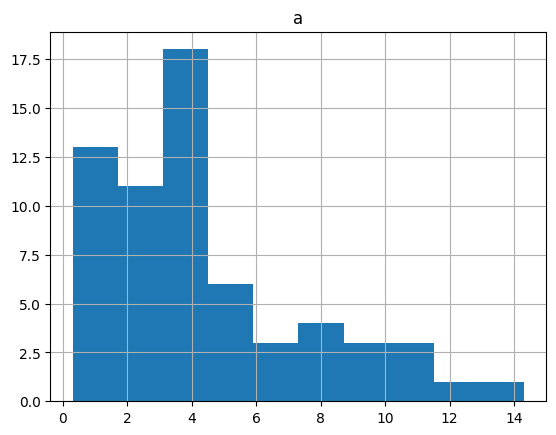

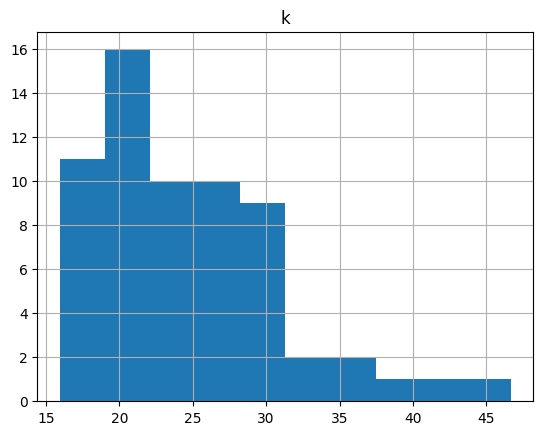

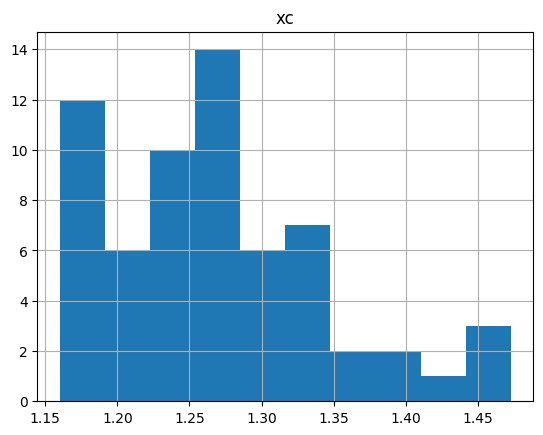

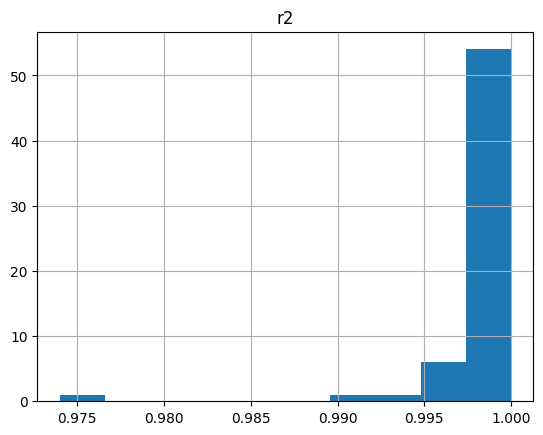

In [7]:
df.hist(column='a')
df.hist(column='k')
df.hist(column='xc')
df.hist(column='r2')